In [1]:
import odl
from skimage.transform import rotate
import scipy.signal
%matplotlib inline
import astra
import numpy as np
import scipy.sparse.linalg
from algorithmImpls import *
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from ImageSliceViewer3D import *
import matplotlib as mpl
from tqdm import tqdm
mpl.rcParams['figure.figsize'] = (10, 10)
font = {'family' : 'normal',
        'size'   : 20}
mpl.rc('font', **font)
from plot_utils import *
from registration_utils import*
from skimage.filters import try_all_threshold, threshold_mean, threshold_minimum, threshold_otsu, threshold_isodata

### Load projection data

In [2]:
def load_volume(filepath):
    files = [file for file in np.sort(listdir(filepath)) if file.endswith(".npy")]
    height, width = np.load(join(filepath,files[0])).shape
    depth = len(files)
    volume = np.zeros((depth, height, width))
    for i,file in tqdm(enumerate(files)):
        volume[i,:,:] = np.load(join(filepath,file))

    volume = volume[:,:,:].astype('float32')
    return volume

volume = load_volume("../PhantomGenerator/output/slow_fast_big")
volume = volume[:,32:480,32:480].astype('float32')
volume.shape

240it [00:00, 481.83it/s]


(240, 448, 448)

### Define parameters for reconstruction which are equal for all algorithms

In [3]:
num_angles = 30#number of angles pr. frame
num_angles_pi = 30 #number of angles for one full rotation

frames, szrow, szcol = volume.shape

bsex = np.sum(volume[:,:,:], axis=1).flatten()

e = np.random.random(frames*szcol)
rho = 0.01
e = rho*np.linalg.norm(bsex)*e/np.linalg.norm(e)
bs = bsex + e;

sinogram = bs.reshape(frames, szcol)

all_angles = np.linspace(0.0,8.03*np.pi, 240, endpoint=True)


strt_stp_idx = int(num_angles/2)
frame_idx = np.array((range(0,frames)))
frames_to_reconstruct = np.array([0, 35, 175, 200])

ground_truth = load_volume("../PhantomGenerator/output/slow_fast_big_no_rot")[strt_stp_idx:-strt_stp_idx,106:406,106:406]

240it [00:00, 452.45it/s]


In [4]:
volume.shape

(240, 448, 448)

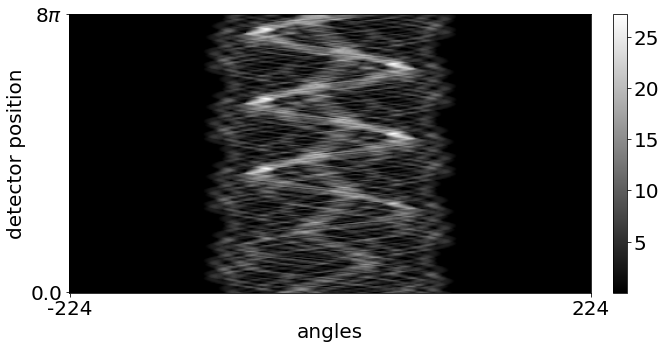

In [22]:
P = sinogram

fig, ax = plt.subplots(1,1)

img = ax.imshow(P, cmap="gray", origin='lower')

x_label_list = ["-224", '224']

ax.set_xticks([0,448])

ax.set_xticklabels(x_label_list)

y_label_list = ["0.0", r"$8\pi$"]

ax.set_yticks([0,239])

ax.set_yticklabels(y_label_list)

ax.set_xlabel("angles")
ax.set_ylabel("detector position")

fig.colorbar(img, fraction=0.025, pad=0.04)

plt.savefig("sinogram.png")

Rotate ground truth to match reconstrcution from 0-pi. Due to inaccuracies it seems total rotation was 8.03 pi. 

In [6]:
#align with reconstruction. I think pi is somewhat inaccurate in blender and everything is a little misaligned.
#It's a dirty hack but it work for now
for frame in range(ground_truth.shape[0]):
    ground_truth[frame,:,:] = rotate(ground_truth[frame,:,:].T,93+0.02*frame)#-54+0.02*frame)

(-0.5, 299.5, 299.5, -0.5)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


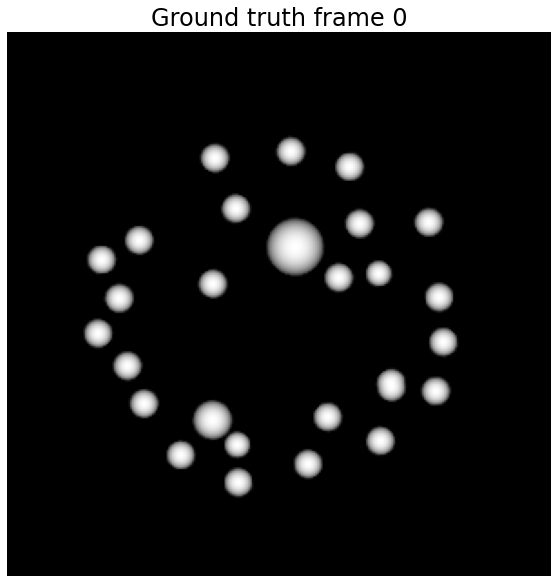

In [7]:
im = ground_truth[0,:,:]
plt.imshow(im, cmap="gray")
plt.title(f"Ground truth frame {0}")
plt.axis("off")

### Angle scheme:

In [8]:
all_angles[frames_to_reconstruct]

array([  0.        ,   3.69432893,  18.47164467,  21.11045105])

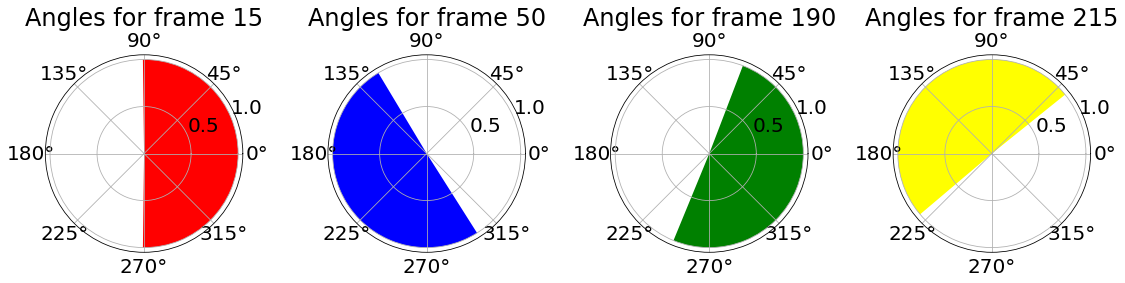

In [9]:
color_list = ['red', 'blue', 'green', 'yellow']
theta = all_angles[frames_to_reconstruct]
width = abs(all_angles[frames_to_reconstruct]-all_angles[frames_to_reconstruct+30])

fig, ax = plt.subplots(1,len(theta), figsize=(16,8), subplot_kw={'projection': 'polar'})

for i,t in enumerate(theta):
    ax[i].bar(t, 1, width=width[i], bottom=0.0, color=color_list[i])
    ax[i].set_title(f'Angles for frame {frames_to_reconstruct[i]+15}')

plt.savefig("anglescheme.png")
fig.tight_layout()
plt.show()

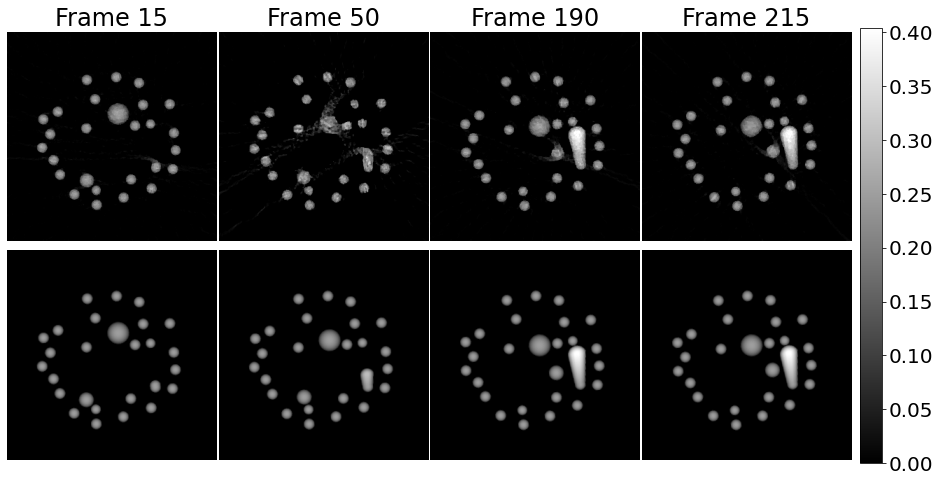

In [15]:
fig, ax = plt.subplots(2,len(frames_to_reconstruct), figsize=(16,8))

vmin = np.min(ground_truth)
vmax = np.max(ground_truth)


for i,f in enumerate(frames_to_reconstruct):
    P = sinogram[f:f+num_angles]

    reco_space = odl.uniform_discr(
        min_pt=[-150, -150], max_pt=[150, 150], shape=[300, 300], dtype='float32')

    angle_partition = odl.uniform_partition(all_angles[f], all_angles[f+num_angles], num_angles)
    detector_partition = odl.uniform_partition(-224, 224, szrow)
    geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)
    reco = TVRecon(P, geometry, reco_space, 0.1, niter=1000).data
    im = ax[1,i].imshow(ground_truth[f,:,:], cmap="gray", vmin=vmin, vmax=vmax)
    ax[1,i].axis("off")
    ax[0,i].set_title(f'Frame {frames_to_reconstruct[i]+15}')
    ax[0,i].imshow(reco, cmap="gray", vmin=vmin, vmax=vmax)
    ax[0,i].axis("off")

#fig.colorbar(im, ax=ax.ravel().tolist())
plt.subplots_adjust(wspace=0.01, hspace=0.01)
fig.colorbar(im, ax=ax.ravel().tolist(), fraction=0.045, pad=0.01)
plt.savefig("TVdynamic.png")

plt.show()

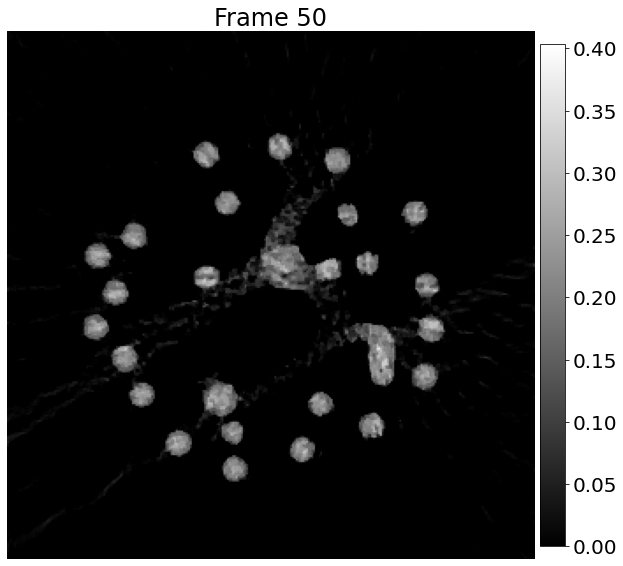

In [16]:
P = sinogram[35: 35+30]

reco_space = odl.uniform_discr(
    min_pt=[-150, -150], max_pt=[150, 150], shape=[300, 300], dtype='float32')

angle_partition = odl.uniform_partition(all_angles[35], all_angles[35+30], 30)
detector_partition = odl.uniform_partition(-224, 224, szrow)
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)
reco = TVRecon(P, geometry, reco_space, 0.1, niter=1000).data
im = plt.imshow(reco, cmap="gray", vmin=vmin, vmax=vmax)
plt.colorbar(im, fraction=0.045, pad=0.01)
plt.title("Frame 50")
plt.axis("off")
plt.savefig("TVdynamic_frame_50.png")


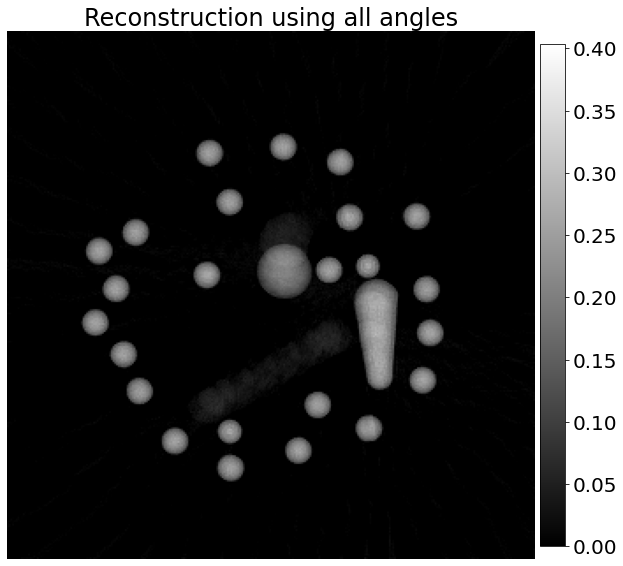

In [17]:
P = sinogram

reco_space = odl.uniform_discr(
    min_pt=[-150, -150], max_pt=[150, 150], shape=[300, 300], dtype='float32')

angle_partition = odl.uniform_partition(all_angles[0], all_angles[-1], 240)
detector_partition = odl.uniform_partition(-224, 224, szrow)
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)
reco = TVRecon(P, geometry, reco_space, 0.1, niter=1000).data
im = plt.imshow(reco, cmap="gray", vmin=vmin, vmax=vmax)
plt.colorbar(im, fraction=0.045, pad=0.01)
plt.title("Reconstruction using all angles")
plt.axis("off")
plt.savefig("TVdynamic_all.png")


Compared to FBP:

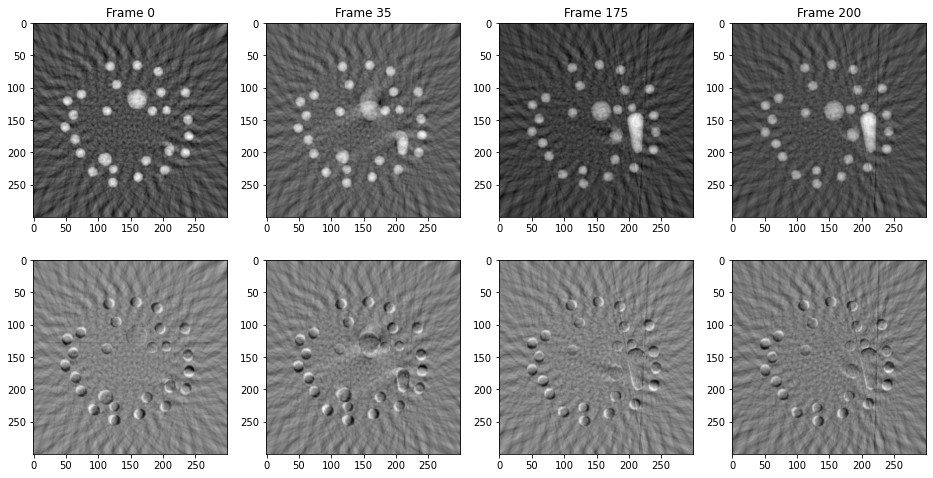

In [21]:
fig, ax = plt.subplots(2,len(frames_to_reconstruct), figsize=(16,8))

for i,f in enumerate(frames_to_reconstruct):
    vol_geom = astra.create_vol_geom(300, 300)
    proj_geom = astra.create_proj_geom('parallel', 1.0, 448, all_angles[f:f+num_angles])
    P = np.sum(volume[:,:,:], axis=1)[f:f+num_angles]

    sino_id = astra.data2d.create('-sino', proj_geom, P)
    rec_id = astra.data2d.create('-vol', vol_geom)
    #proj_id = astra.create_projector('parallel', proj_geom, vol_geom)

    # Configure algorithm
    cfg = astra.astra_dict('FBP_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sino_id
    #cfg['ProjectorDataId'] = proj_id
    alg_id = astra.algorithm.create(cfg)
    # Run
    astra.algorithm.run(alg_id, 100)
    reco = astra.data2d.get(rec_id)
    reco = np.flip(reco.T, axis=1)
    astra.algorithm.delete(alg_id)
    astra.data3d.delete(rec_id)
    ax[1,i].imshow(reco-ground_truth[f,:,:], cmap="gray")
    ax[0,i].set_title(f'Frame {frames_to_reconstruct[i]}')
    ax[0,i].imshow(reco, cmap="gray")
plt.show()

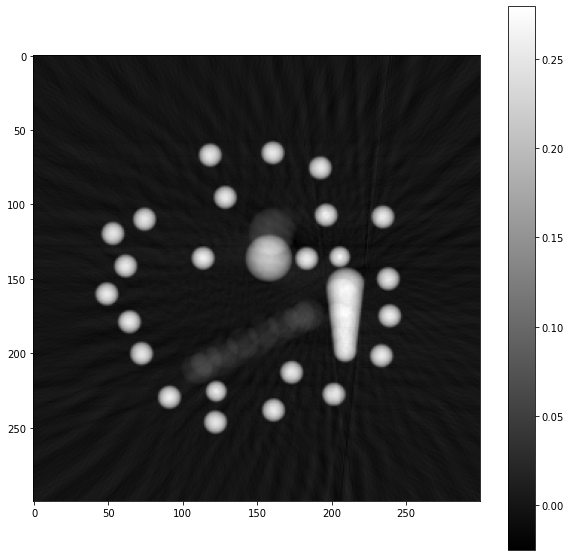

In [24]:
vol_geom = astra.create_vol_geom(300, 300)
proj_geom = astra.create_proj_geom('parallel', 1.0, 448, np.linspace(0, 8.0*np.pi,240))


P = np.sum(volume[:,:,:], axis=1)#[60:90]
sino_id = astra.data2d.create('-sino', proj_geom, P)
rec_id = astra.data2d.create('-vol', vol_geom)
#proj_id = astra.create_projector('parallel', proj_geom, vol_geom)

# Configure algorithm
cfg = astra.astra_dict('FBP_CUDA')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sino_id
#cfg['ProjectorDataId'] = proj_id
alg_id = astra.algorithm.create(cfg)
# Run
astra.algorithm.run(alg_id, 100)
reco = astra.data2d.get(rec_id)

astra.algorithm.delete(alg_id)
astra.data3d.delete(rec_id)
plt.imshow(np.flip(reco.T, axis=1), cmap="gray")
plt.colorbar()
#P.shape

A reconstruction using all angles

### Reconstruction 2D static all data, TV Regularization, different $\lambda$ values

In [25]:
lamdas = [0.5, 0.05, 0.01, 0.001] 
P = np.sum(volume[:,:,:], axis=1)

reco_space = odl.uniform_discr(
    min_pt=[-150, -150], max_pt=[150, 150], shape=[300, 300], dtype='float32')

angle_partition = odl.uniform_partition(all_angles[0], all_angles[-1], 240)
detector_partition = odl.uniform_partition(-224, 224, szrow)
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)
reco = TVRecon(P, geometry, reco_space, 0.1, niter=1000).data

result = np.zeros((len(lamdas), 300, 300))
for i, lamda in tqdm(enumerate(lamdas)):
    result[i,:,:] = TVRecon(P, geometry, reco_space, lamda).data
    
recon = result

4it [00:11,  2.81s/it]


/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


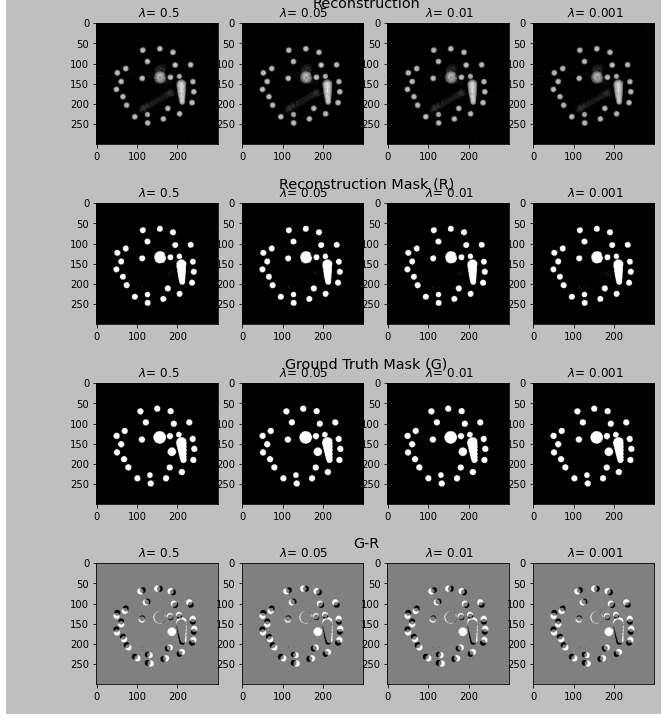

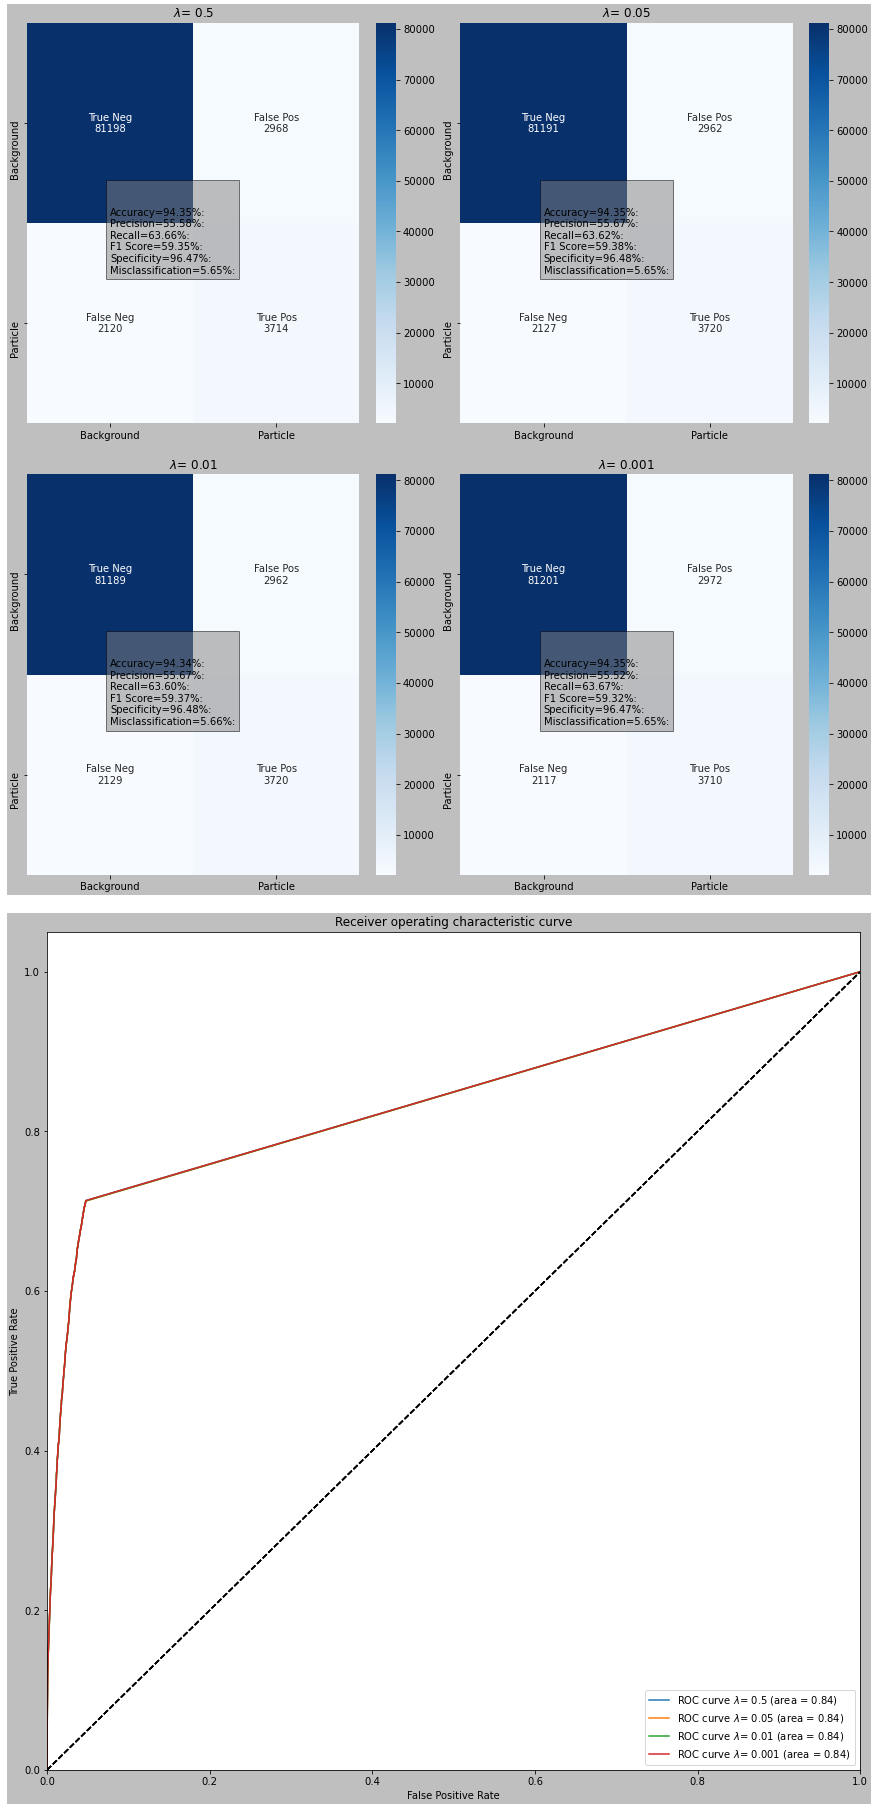

In [26]:
titles = [r'$\lambda$='+f' {l}' for l in lamdas]
GT = np.array([ground_truth[f,:,:]]*len(titles))
plot_results(recon, GT , titles, threshold_minimum, threshold_minimum)
plot_stats(recon, GT, titles, threshold_minimum, threshold_minimum)

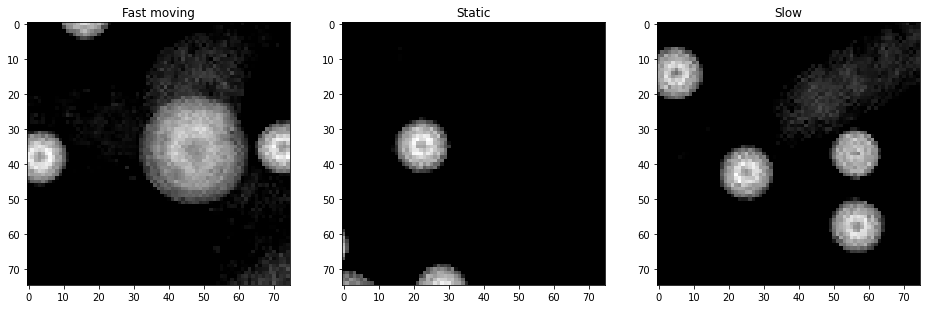

In [27]:
fast = np.index_exp[:,100:175, 110:185]
slow = np.index_exp[:,190:265, 70:145]
static = np.index_exp[:,70:145,210:285]


fig, ax = plt.subplots(1,3, figsize=(16,10))
ax[0].imshow(recon[fast][2], cmap="gray")
ax[0].set_title("Fast moving")
ax[1].imshow(recon[static][2], cmap="gray")
ax[1].set_title("Static")
ax[2].imshow(recon[slow][2], cmap="gray")
ax[2].set_title("Slow")
#ax[0].axis("off")
#ax[1].axis("off")
#ax[2].axis("off")
plt.savefig("TVdynamic.png")

/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


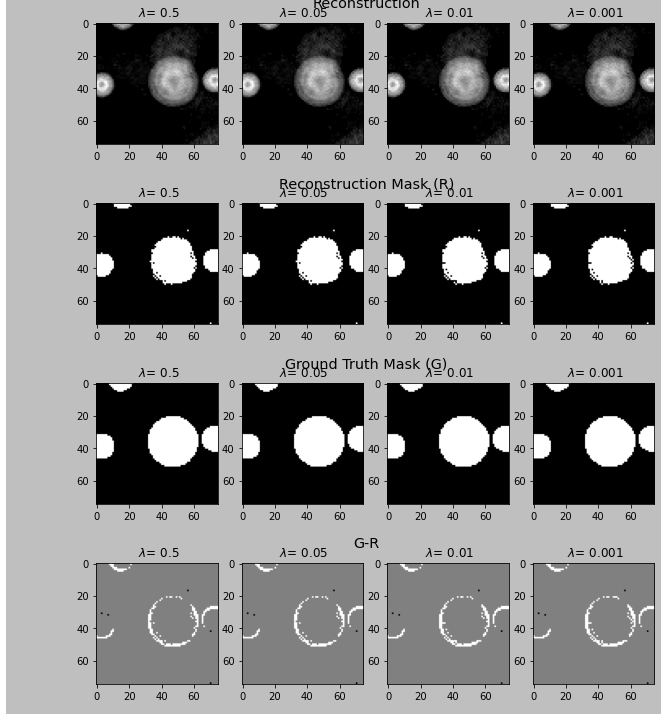

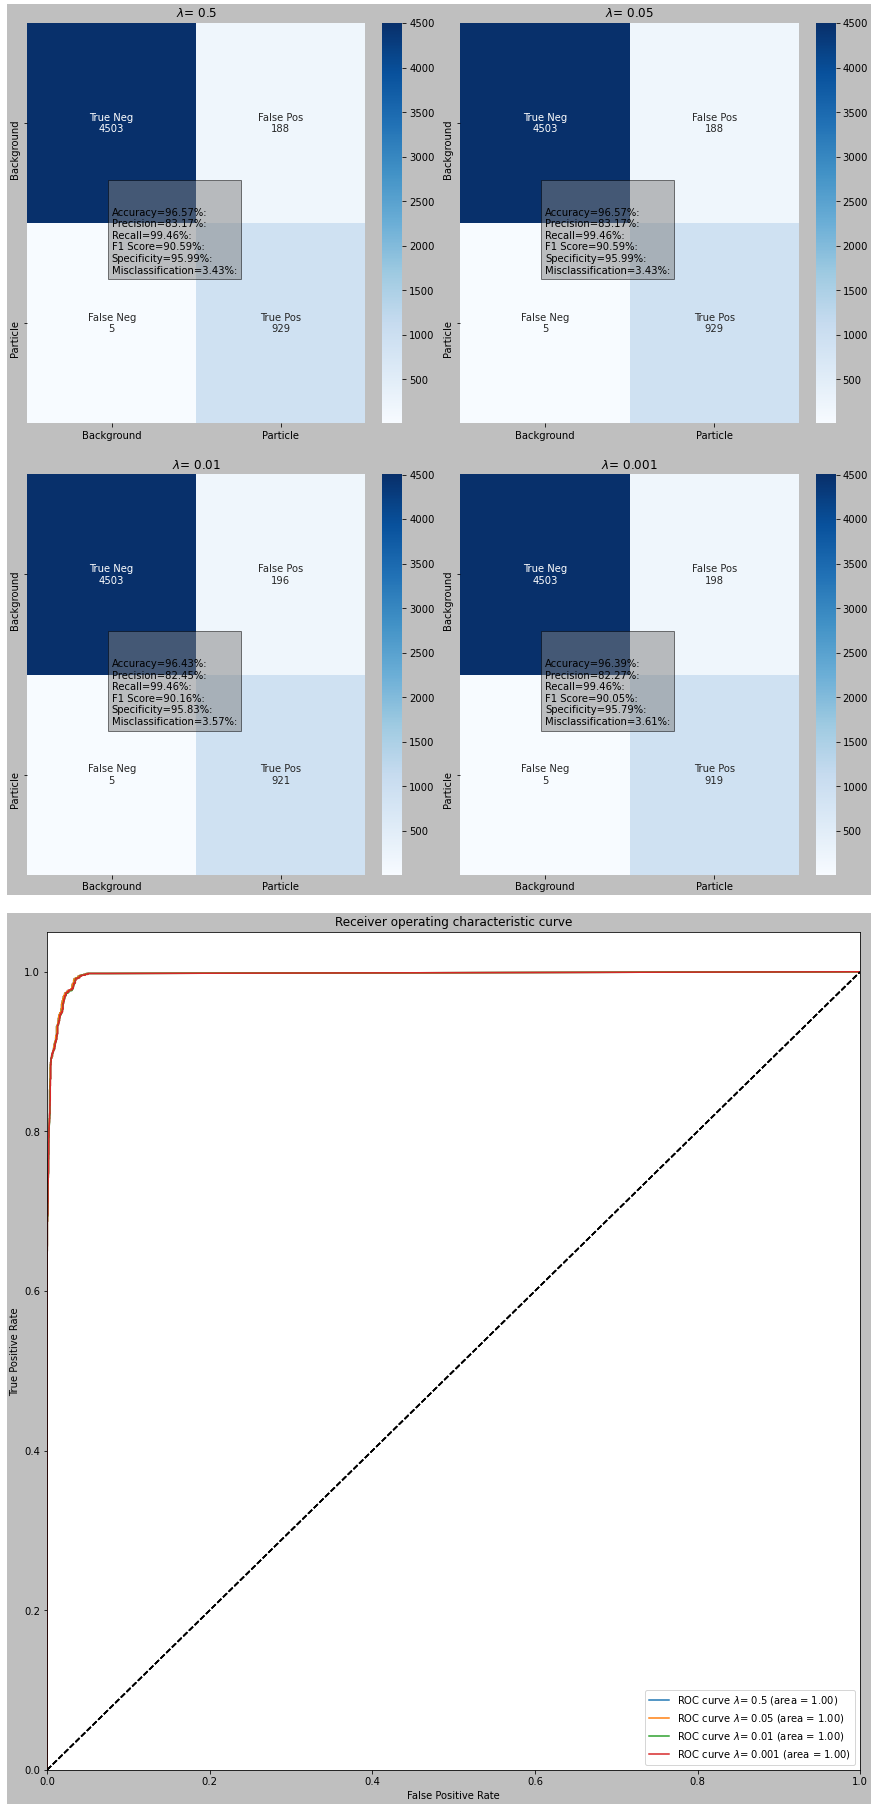

In [28]:
titles = [r'$\lambda$='+f' {l}' for l in lamdas]
GT = np.array([ground_truth[50,:,:]]*len(titles))
plot_results(recon[fast], GT[fast] , titles, threshold_minimum, threshold_minimum)
plot_stats(recon[fast], GT[fast], titles, threshold_minimum, threshold_minimum)

/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


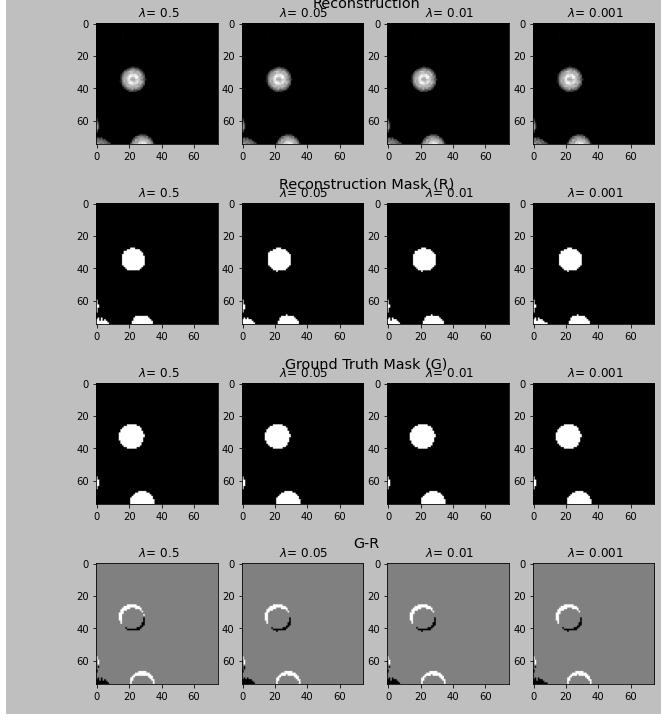

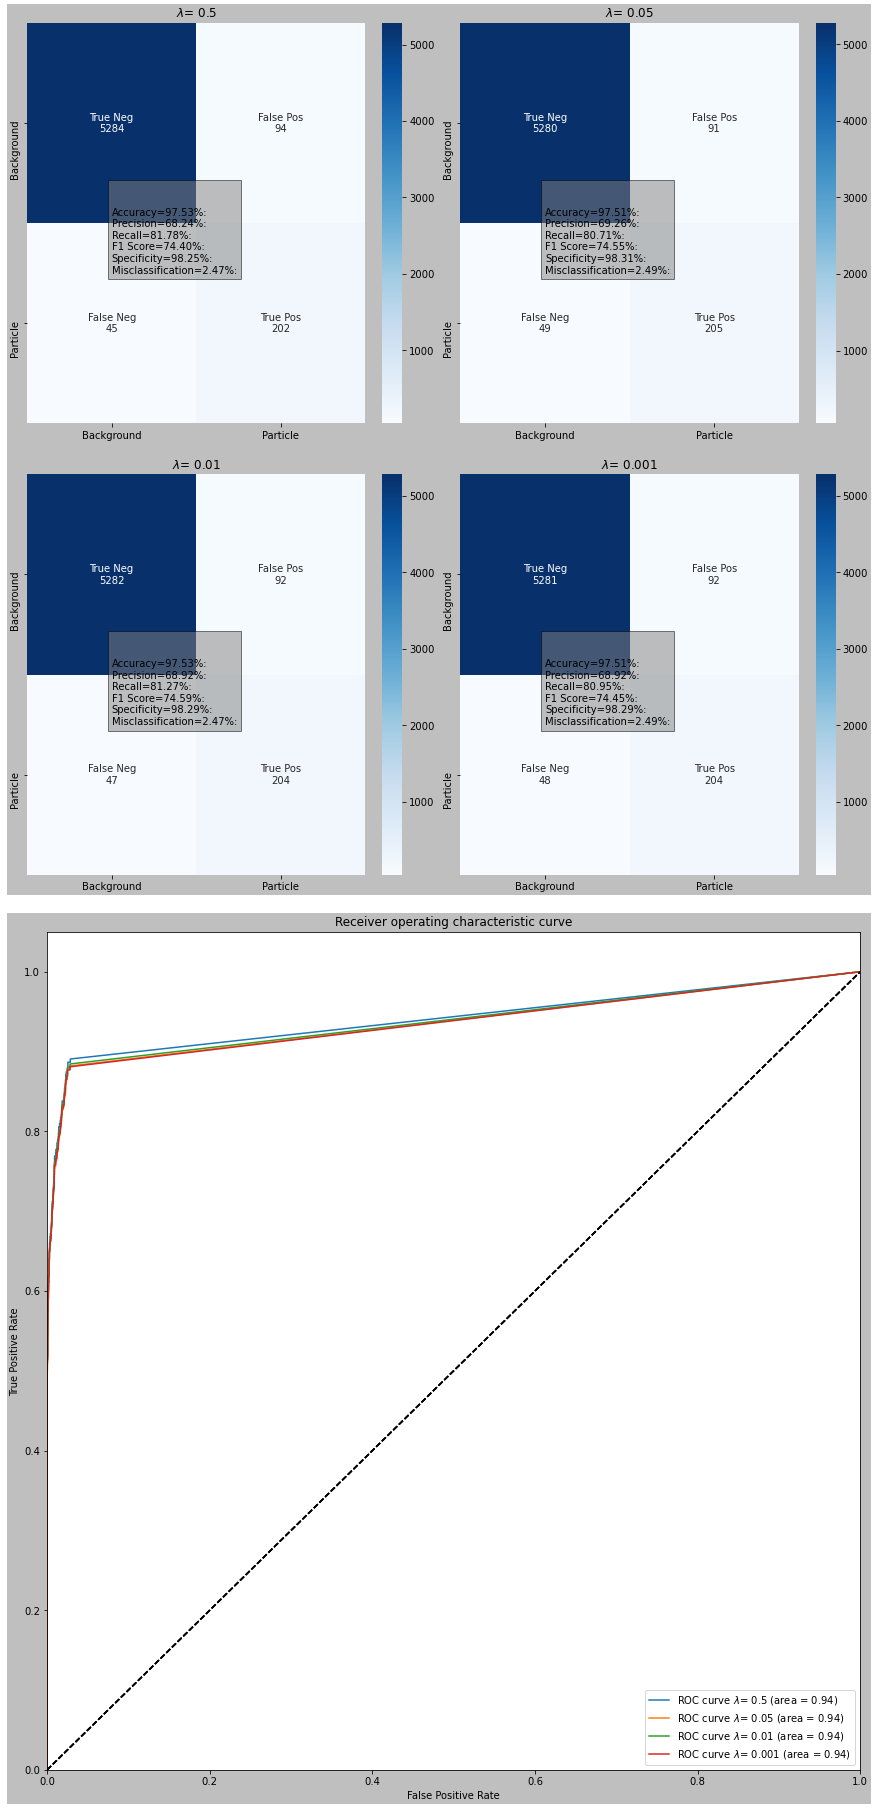

In [29]:
titles = [r'$\lambda$='+f' {l}' for l in lamdas]
GT = np.array([ground_truth[50,:,:]]*len(titles))
plot_results(recon[static], GT[static] , titles, threshold_minimum, threshold_minimum)
plot_stats(recon[static], GT[static], titles, threshold_minimum, threshold_minimum)

/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


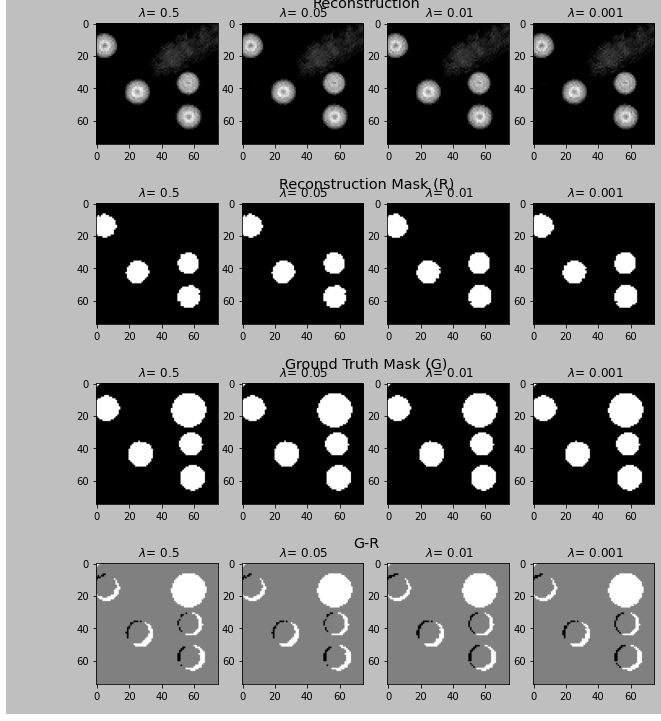

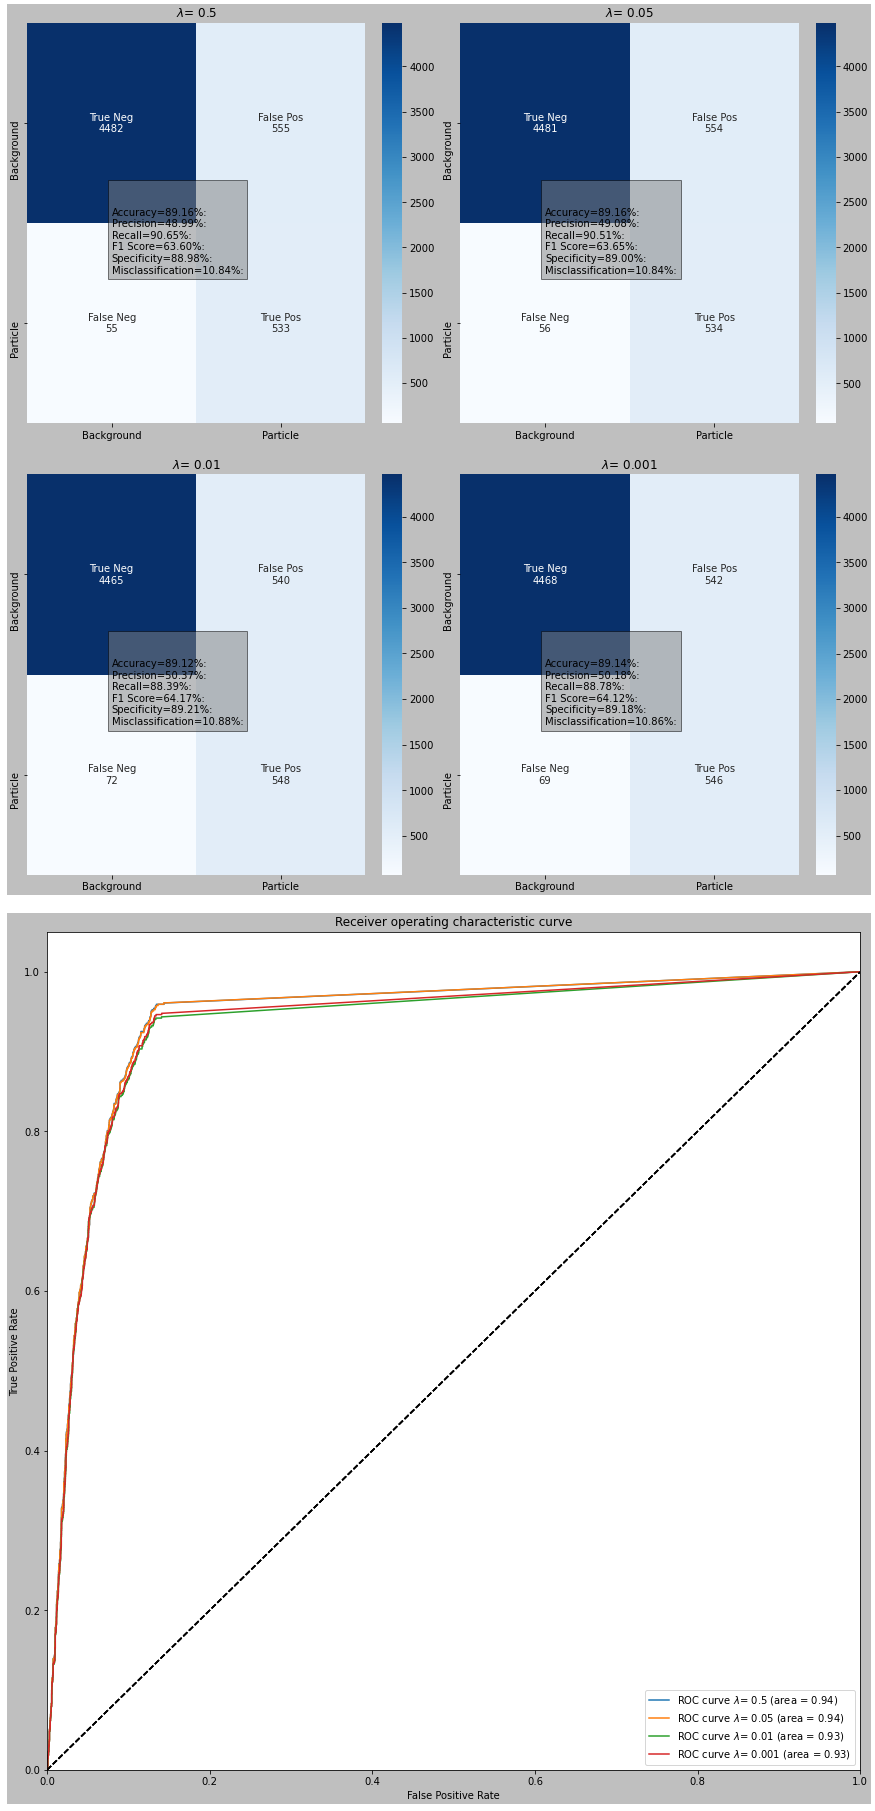

In [30]:
titles = [r'$\lambda$='+f' {l}' for l in lamdas]
GT = np.array([ground_truth[50,:,:]]*len(titles))
plot_results(recon[slow], GT[slow] , titles, threshold_minimum, threshold_minimum)
plot_stats(recon[slow], GT[slow], titles, threshold_minimum, threshold_minimum)

### Reconstruction static 2D frame by frame, TV regularixation at $\lambda=0.01$

In [31]:
lamda = 0.01#this parameter controls degree of regularization - useless for many angles/little noise, smoother reconstructions for few angles

result = np.zeros((len(frames_to_reconstruct), reco_space.shape[0], reco_space.shape[1]))

for i,frame in tqdm(enumerate(frames_to_reconstruct)):
    P = np.sum(volume[:,:,:], axis=1)[frame:frame+num_angles]

    reco_space = odl.uniform_discr(
        min_pt=[-150, -150], max_pt=[150, 150], shape=[300, 300], dtype='float32')

    angle_partition = odl.uniform_partition(all_angles[frame], all_angles[frame+num_angles], num_angles)
    detector_partition = odl.uniform_partition(-224, 224, szrow)
    geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)
    reco = TVRecon(P, geometry, reco_space, 0.1, niter=1000).data
    result[i] = reco

recon_f = result

4it [00:44, 11.16s/it]


In [32]:
all_angles[frames_to_reconstruct]

array([  0.        ,   3.69432893,  18.47164467,  21.11045105])

/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


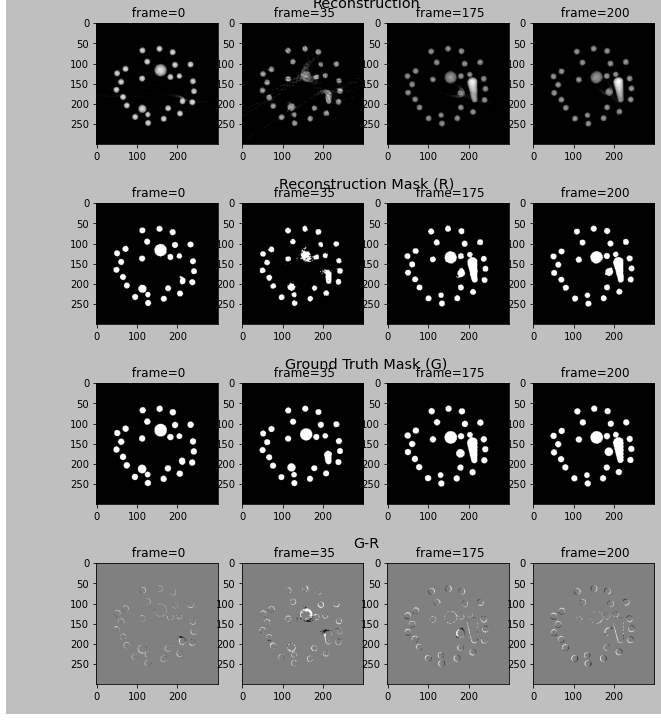

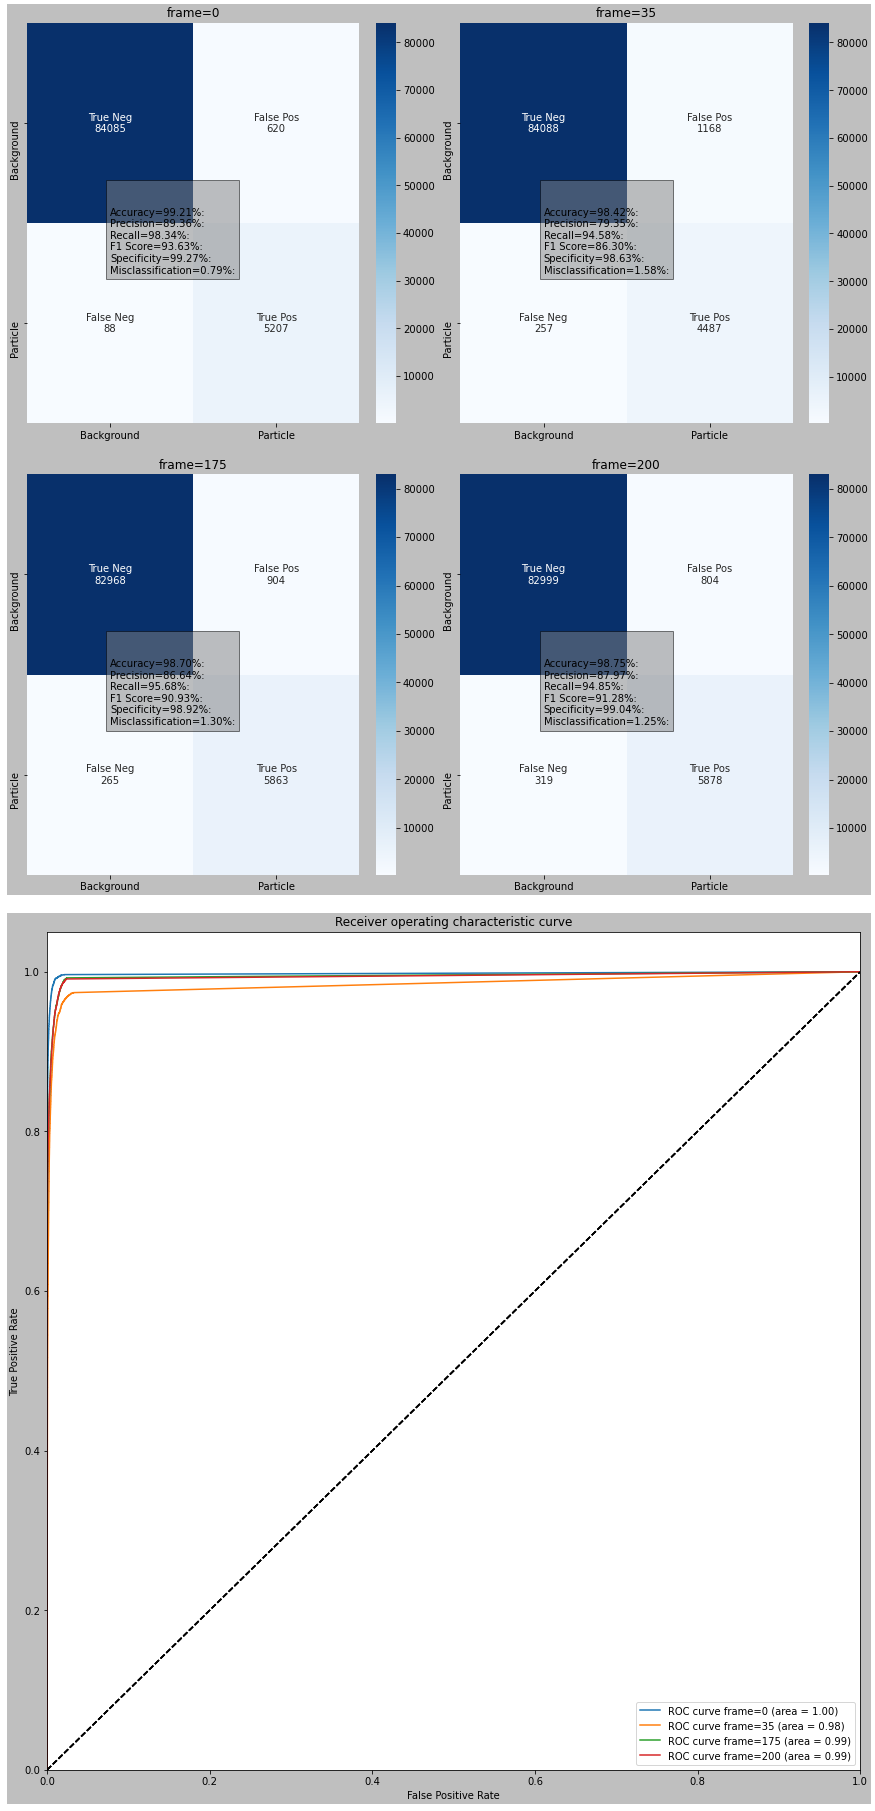

In [33]:
titles = [f'frame={f}' for f in frames_to_reconstruct]
GT = ground_truth[frames_to_reconstruct,:,:]

plot_results(recon_f, GT , titles, threshold_minimum, threshold_minimum)
plot_stats(recon_f, GT, titles, threshold_minimum, threshold_minimum)

/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


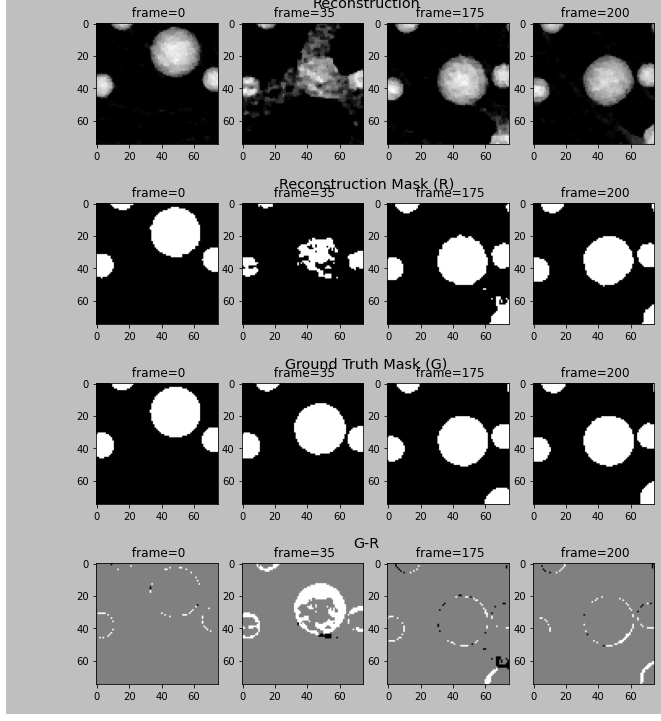

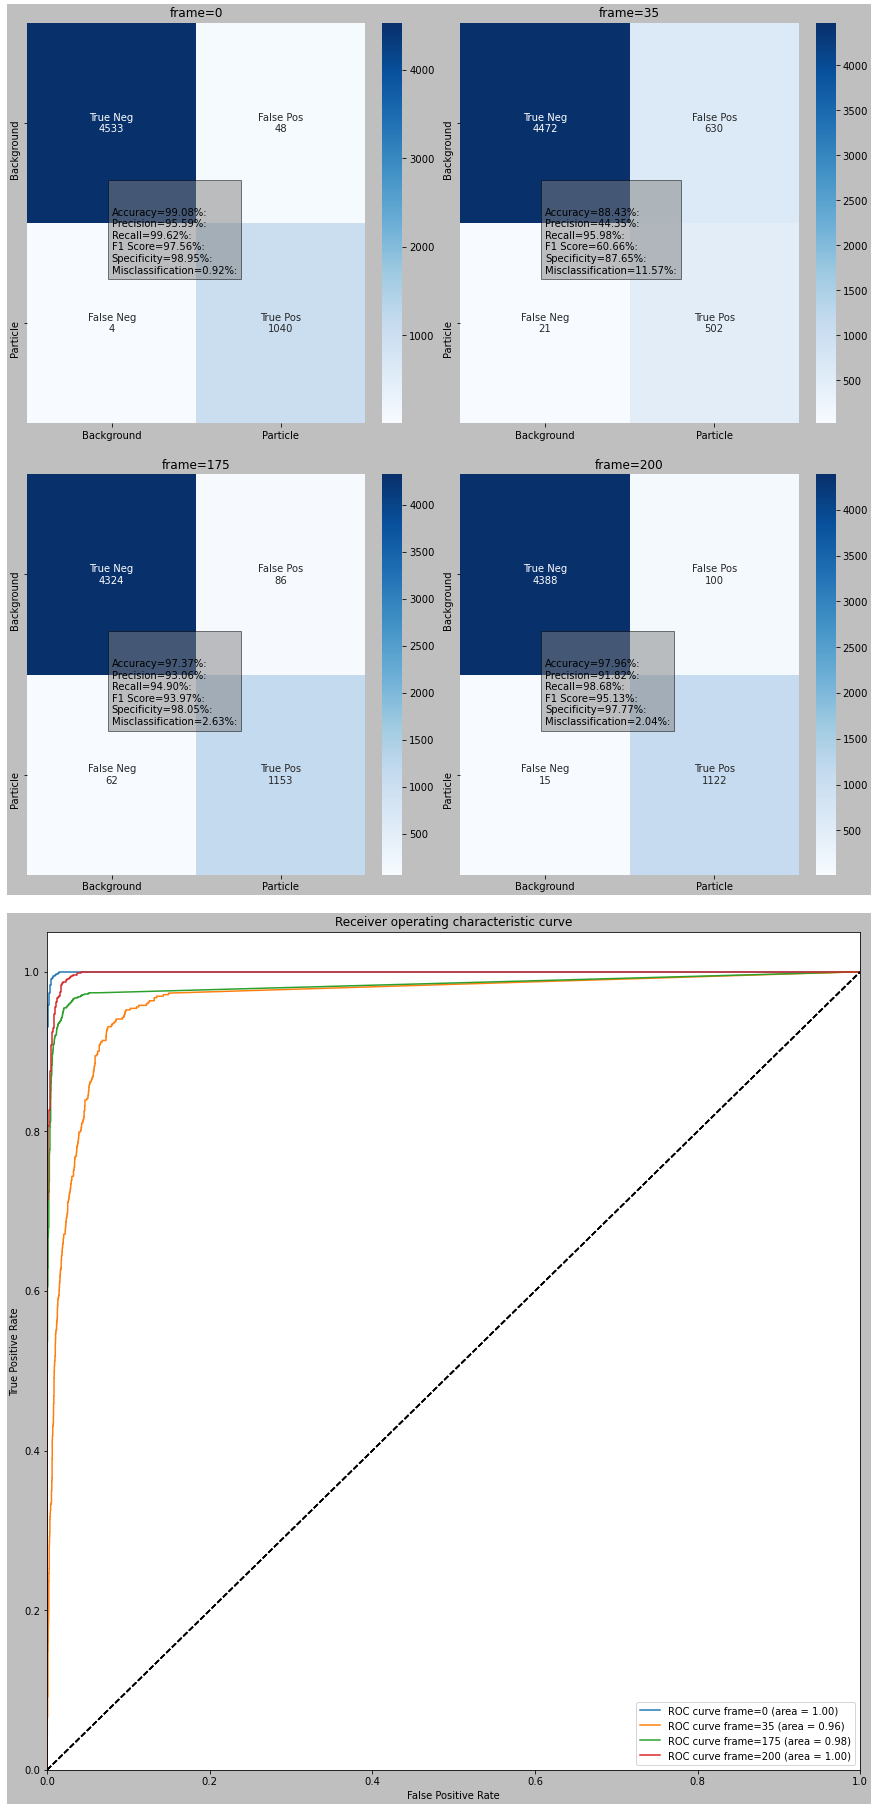

In [34]:
titles = [f'frame={f}' for f in frames_to_reconstruct]
GT = ground_truth[frames_to_reconstruct,:,:]

plot_results(recon_f[fast], GT[fast] , titles, threshold_minimum, threshold_minimum)
plot_stats(recon_f[fast], GT[fast], titles, threshold_minimum, threshold_minimum)

/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


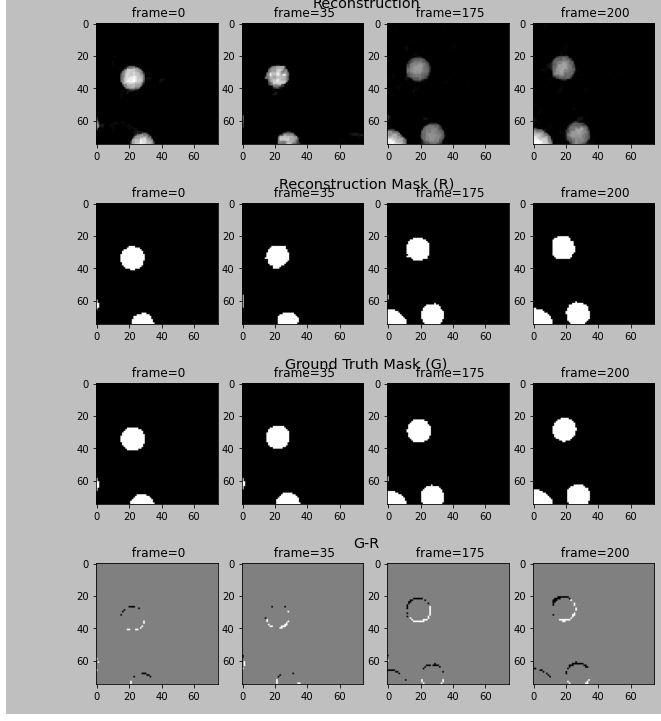

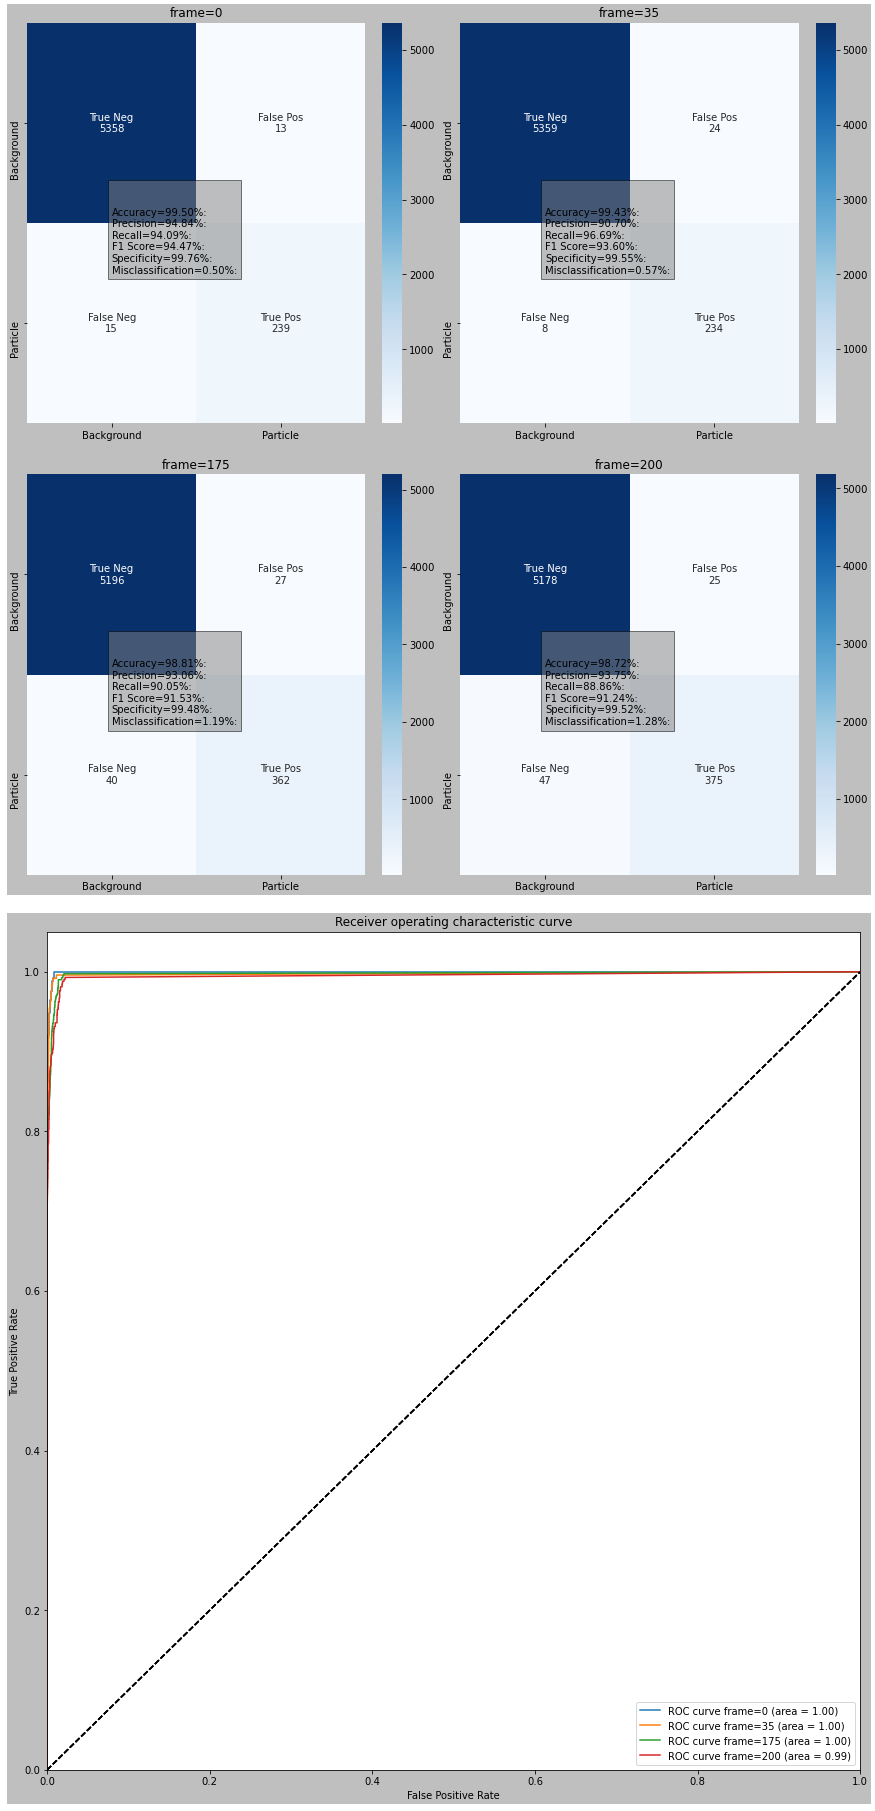

In [35]:
titles = [f'frame={f}' for f in frames_to_reconstruct]
GT = ground_truth[frames_to_reconstruct,:,:]

plot_results(recon_f[static], GT[static] , titles, threshold_minimum, threshold_minimum)
plot_stats(recon_f[static], GT[static], titles, threshold_minimum, threshold_minimum)

/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


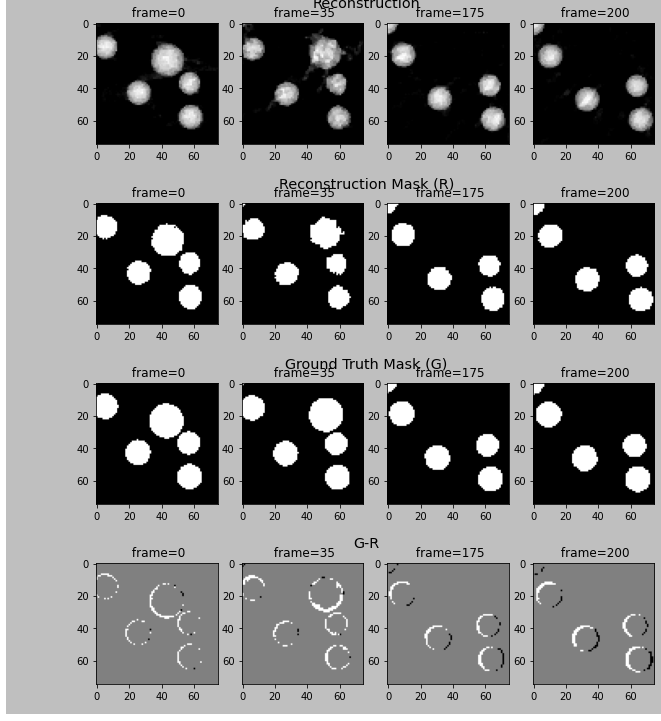

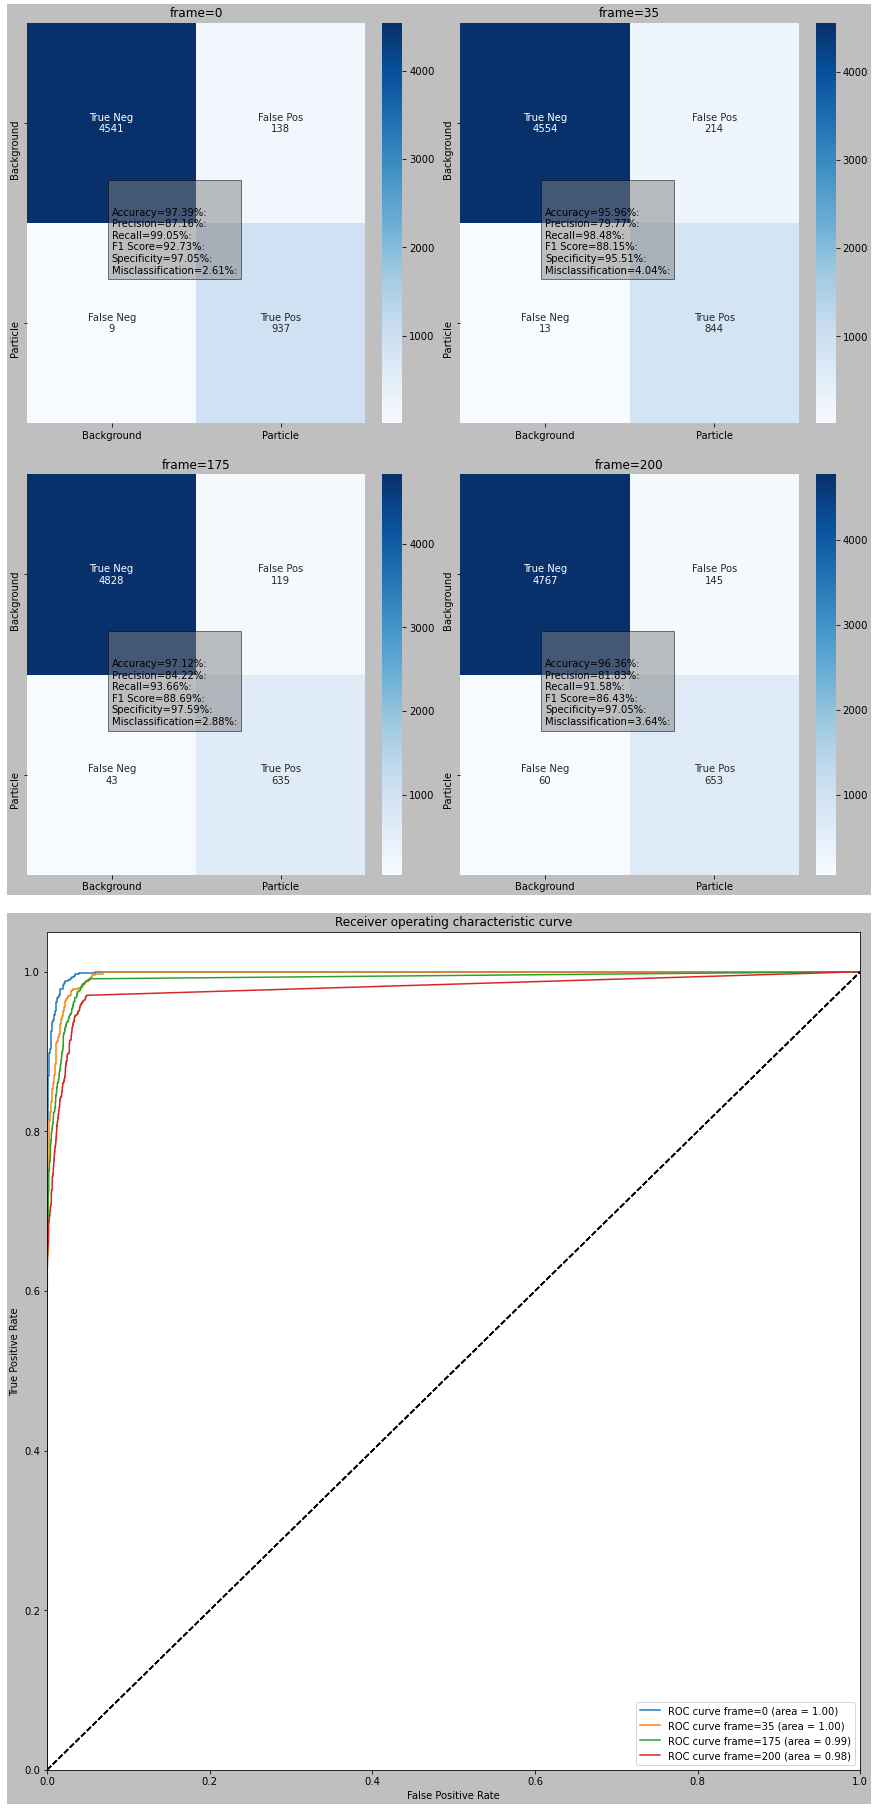

In [36]:
titles = [f'frame={f}' for f in frames_to_reconstruct]
GT = ground_truth[frames_to_reconstruct,:,:]

plot_results(recon_f[slow], GT[slow] , titles, threshold_minimum, threshold_minimum)
plot_stats(recon_f[slow], GT[slow], titles, threshold_minimum, threshold_minimum)

### Reconstruction with TV regularization in time dimension, $\lambda_1=0.01$, frame = 50, varying  $\lambda_2$

In [37]:

lamda1 = 0.01
lamda2 = np.array([0.1, 1.0, 5.0, 10.0])

#to save time lets just use frames 0-100. Should be enough. We're only looking at frame 50 and most movement occurs frame 40-60, meaning by using angles 0-100 we get 40 angles with very little movement and we're using 30 for reconstructing each frame
f=35
frame_used_in_recon = 100
sz = 300
ts = range(0,frame_used_in_recon)
thetas_all = all_angles[0:frame_used_in_recon]#np.array([theta_from_t(t) for t in ts]) #angles for full acquisition
detector_partition = odl.uniform_partition(-224, 224, 448)#last number max_pt is important
reconstruction_space = odl.uniform_discr(min_pt=[-150, -150, 0], max_pt=[150, 150, 1], shape=[sz, sz, 70], dtype='float32')

recon_t = np.zeros((len(lamda2), sz,sz))
for i,l in tqdm(enumerate(lamda2)):
    x, sinogram_spaces = TVReconTime(np.sum(volume[0:frame_used_in_recon,:,:], axis=1), reconstruction_space, lamda1, l, frame_used_in_recon-num_angles, thetas_all, 30, detector_partition)
    recon_t[i,:,:] = x.data[:,:,f]

4it [10:30, 157.66s/it]


In [18]:
titles = [r'$\lambda_2=$'+f'{l}' for l in lamda2]
GT = np.array([ground_truth[50,:,:]]*len(titles))

p1 = plot_results(recon_t, GT , titles, threshold_minimum, threshold_minimum)
p2 = plot_stats(recon_t, GT, titles, threshold_minimum, threshold_minimum)

NameError: name 'lamda2' is not defined

In [17]:
titles = [r'$\lambda_2=$'+f'{l}' for l in lamda2]
GT = np.array([ground_truth[50,:,:]]*len(titles))

plot_results(recon_t[fast], GT[fast] , titles, threshold_minimum, threshold_minimum)
plot_stats(recon_t[fast], GT[fast], titles, threshold_minimum, threshold_minimum)

NameError: name 'lamda2' is not defined

In [ ]:
titles = [r'$\lambda_2=$'+f'{l}' for l in lamda2]
GT = np.array([ground_truth[50,:,:]]*len(titles))

plot_results(recon_t[static], GT[static] , titles, threshold_minimum, threshold_minimum)
plot_stats(recon_t[static], GT[static], titles, threshold_minimum, threshold_minimum)

In [ ]:
titles = [r'$\lambda_2=$'+f'{l}' for l in lamda2]
GT = np.array([ground_truth[50,:,:]]*len(titles))

plot_results(recon_t[slow], GT[slow] , titles, threshold_minimum, threshold_minimum)
plot_stats(recon_t[slow], GT[slow], titles, threshold_minimum, threshold_minimum)